In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import cv2

# Reverse Image Search a.k.a. Instance Retrieval

Because our aim is to search among millions of images, what we ideally need is a way to summarize the information contained in the millions of pixels in an image into a smaller representation (of say a few thousand dimensions), and have this summarized representation be close together for similar objects and further away for dissimilar items.

CNNs take an image input and convert it into feature vectors of a thousand dimensions, which then act as input to a classifier that outputs the top identities to which the image might belong (say dog or cat). The feature vectors (also called embeddings or bottleneck features) are essentially a collection of a few thousand floating-point values. Going through the convolution and pooling layers in a CNN is basically an act of reduction, to filter the information contained in the image to its most important and salient constituents, which in turn form the bottleneck features. Training the CNN molds these values in such a way that items belonging to the same class have small Euclidean distance between them (or simply the square root of the sum of squares of the difference between corresponding values) and items from different classes are separated by larger distances. This is an important property that helps solve so many problems where a classifier can’t be used, especially in unsupervised problems because of a lack of adequate labeled data.



# Feature Extraction


Load the ResNet-50 model without the top classification layers, so we get only the bottleneck features. Then define a function that takes an image path, loads the image, resizes it to proper dimensions supported by ResNet-50, extracts the features, and then normalizes them:

In [2]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

2021-10-31 02:42:32.629509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 02:42:32.724043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 02:42:32.724765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-31 02:42:32.725820: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [3]:
def extract_features(img_path, model):
    
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    
    expanded_img_array = np.expand_dims(img_array, axis=0)
    
    preprocessed_img = preprocess_input(expanded_img_array)
    
    features = model.predict(preprocessed_img)
    
    normalized_features = features / norm(features)
    
    return normalized_features

That’s it! Let’s see the feature-length that the model generates:

In [4]:
features = extract_features('../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg', model)[0]
print(len(features))

2021-10-31 02:42:37.078598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-31 02:42:38.834523: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2048


The ResNet-50 model generated 2,048 features from the provided image. Each feature is a floating-point value between 0 and 1.

In [5]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

Then, we provide the path to our dataset and call the function:

In [6]:
# path to the datasets
root_dir = '../input/petfinder-pawpularity-score/train'
filenames = sorted(get_file_list(root_dir))

We now define a variable that will store all of the features, go through all filenames in the dataset, extract their features, and append them to the previously defined variable:

In [7]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model)[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/9912 [00:00<?, ?it/s]

# Similarity Search

Given a photograph, our aim is to find another photo in our dataset similar to the current one.
We’ll use Python’s machine learning library scikit-learn for finding nearest neighbors of the query features; that is, features that represent a query image. We train a nearest-neighbor model to find the nearest ten neighbors based on Euclidean distance.

In [8]:
neighbors = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(feature_list)

In [9]:
def plot_images(paths, title):
    plt.figure(figsize=(20,20))
    for i, path in enumerate(paths):
        plt.subplot(1, len(paths), i+1)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Distance: {title[i]:.2f}')
    plt.show()

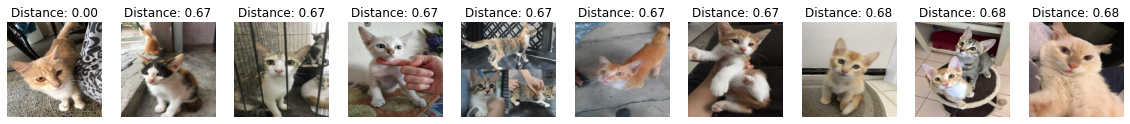

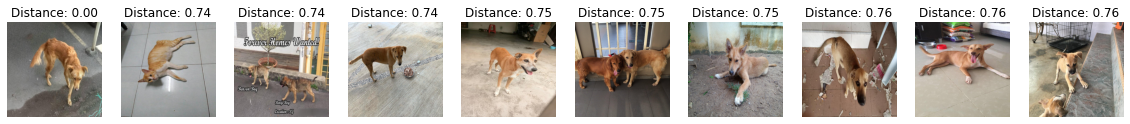

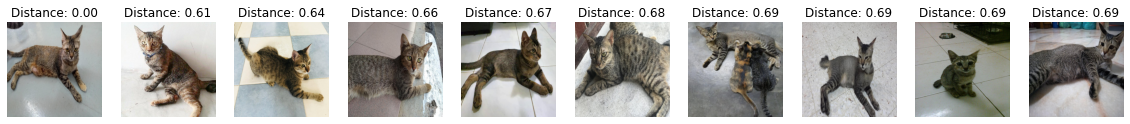

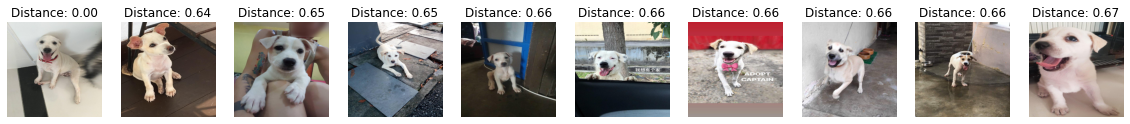

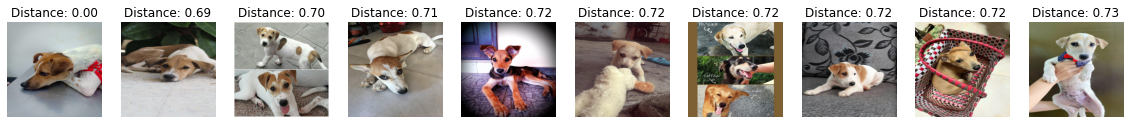

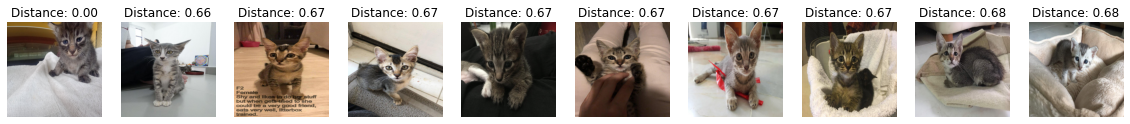

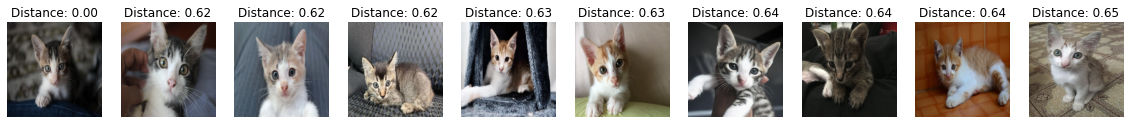

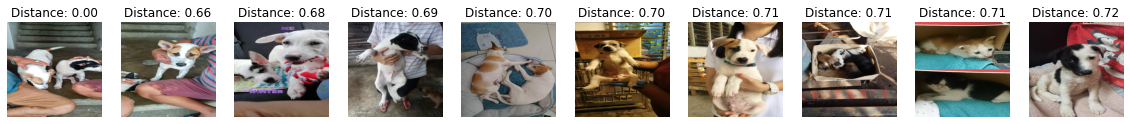

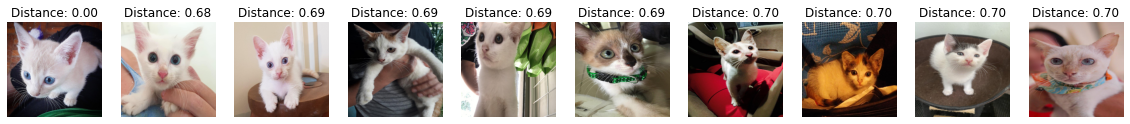

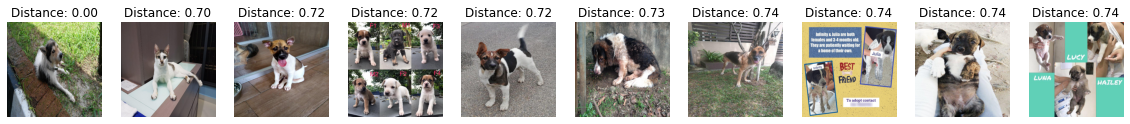

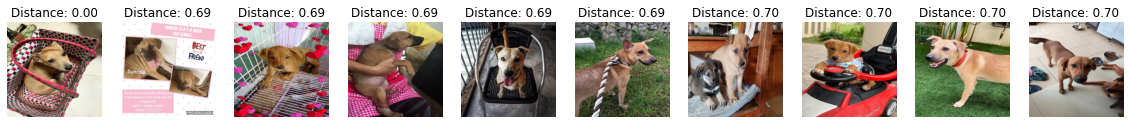

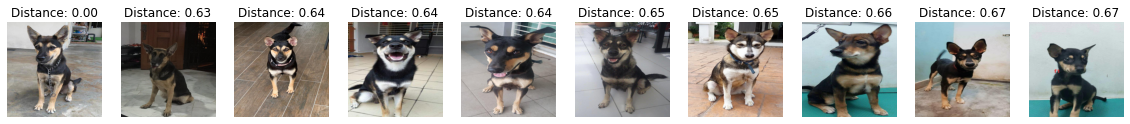

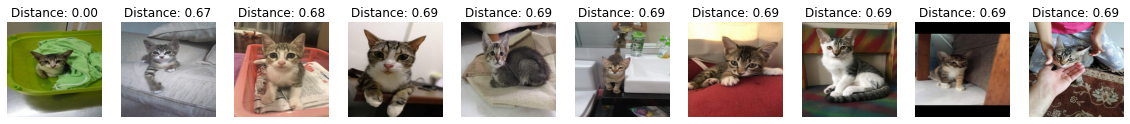

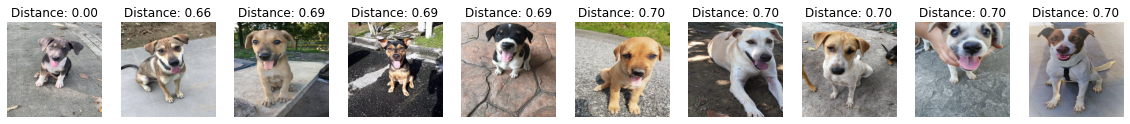

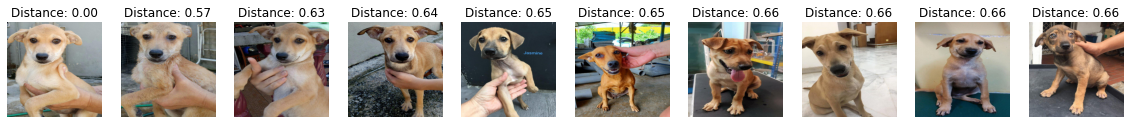

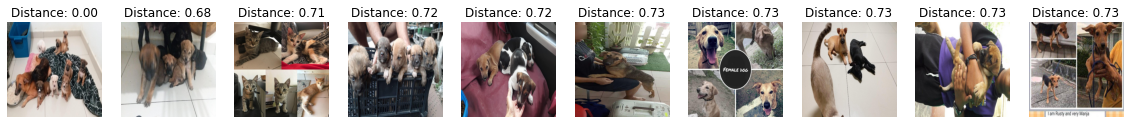

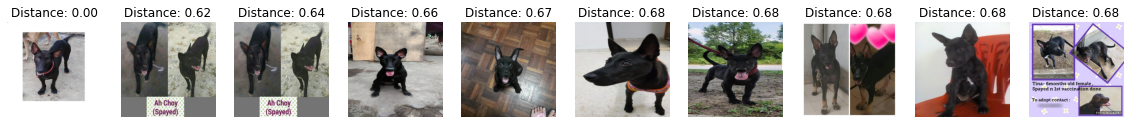

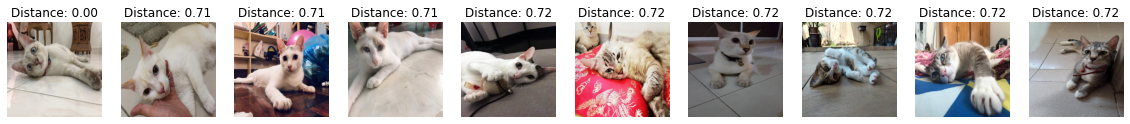

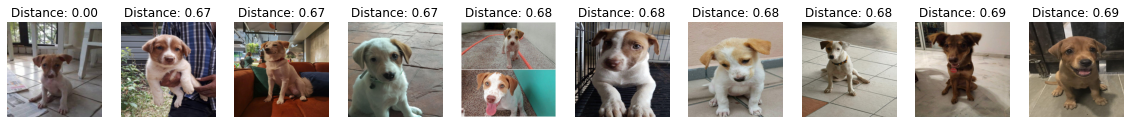

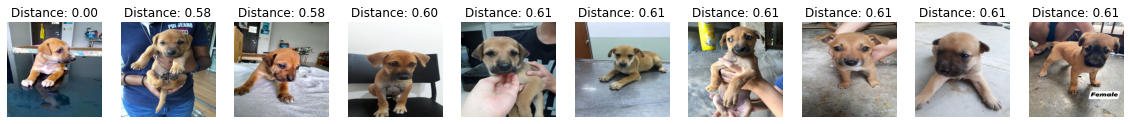

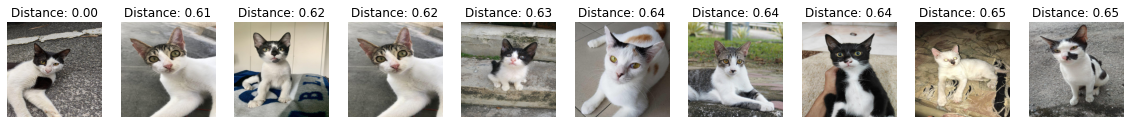

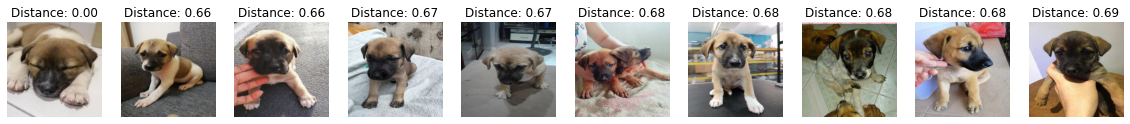

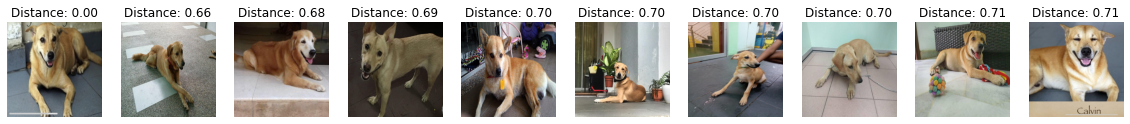

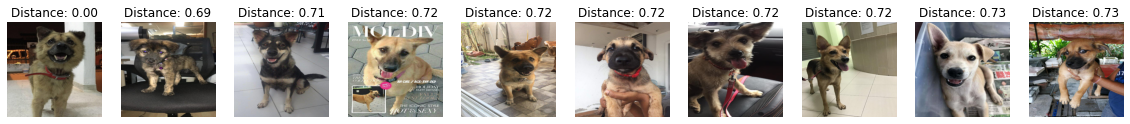

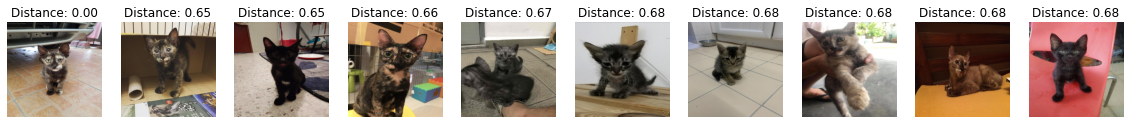

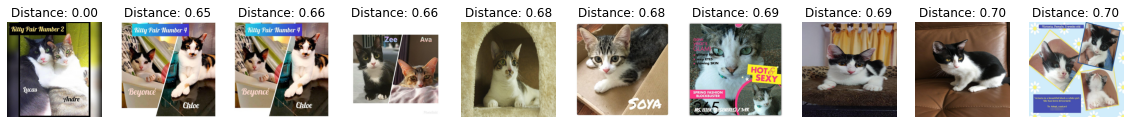

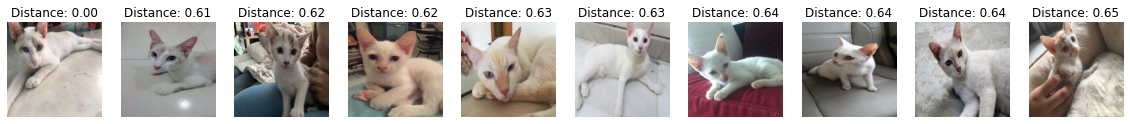

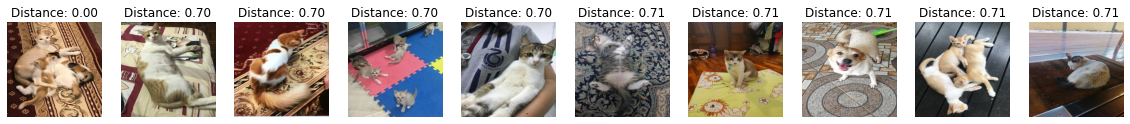

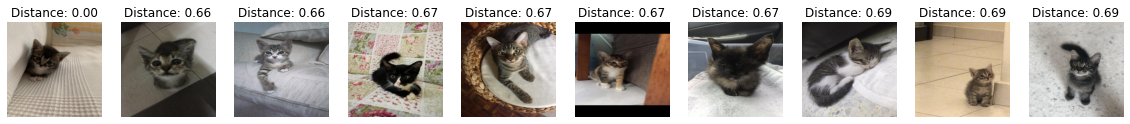

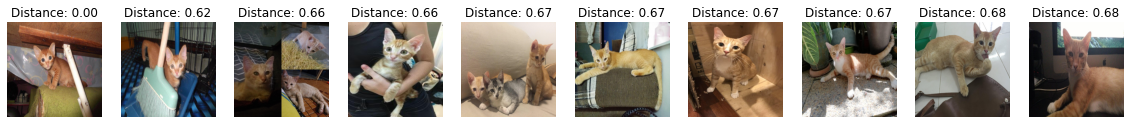

In [10]:
for i in range(30):
    random_image_index = np.random.randint(0,len(filenames))
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,10)]
    plot_images(similar_image_paths, distances[0])

# Visualizing Image Clusters with t-SNE

Let’s step up the game by visualizing the entire dataset! To do this, we need to reduce the dimensions of the feature vectors because it’s not possible to plot a 2,048-dimension vector (the feature-length) in two dimensions (the paper). The t-distributed stochastic neighbor embedding (t-SNE) algorithm reduces the high dimensional feature vector to 2D, providing a bird’s-eye view of the dataset, which is helpful in recognizing clusters and nearby images. t-SNE is difficult to scale to large datasets, so it is a good idea to reduce the dimensionality using Principal Component Analysis (PCA) and then call t-SNE:


In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [12]:
# Perform PCA over the features
pca = PCA(n_components = 100)
feature_list_compressed = pca.fit_transform(feature_list)

# Select random data points
number_of_data_points = 1000
random_indexes = np.random.randint(0,len(feature_list_compressed),number_of_data_points)

selected_features = [feature_list_compressed[index] for index in random_indexes]
selected_filenames = [filenames[index] for index in random_indexes]

In [13]:
images = []
for file in selected_filenames:
    i = cv2.imread(file)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i = cv2.resize(i,(64,64))
    images.append(i)  

In [14]:
tsne_results = TSNE(n_components=2, metric='euclidean').fit_transform(selected_features)

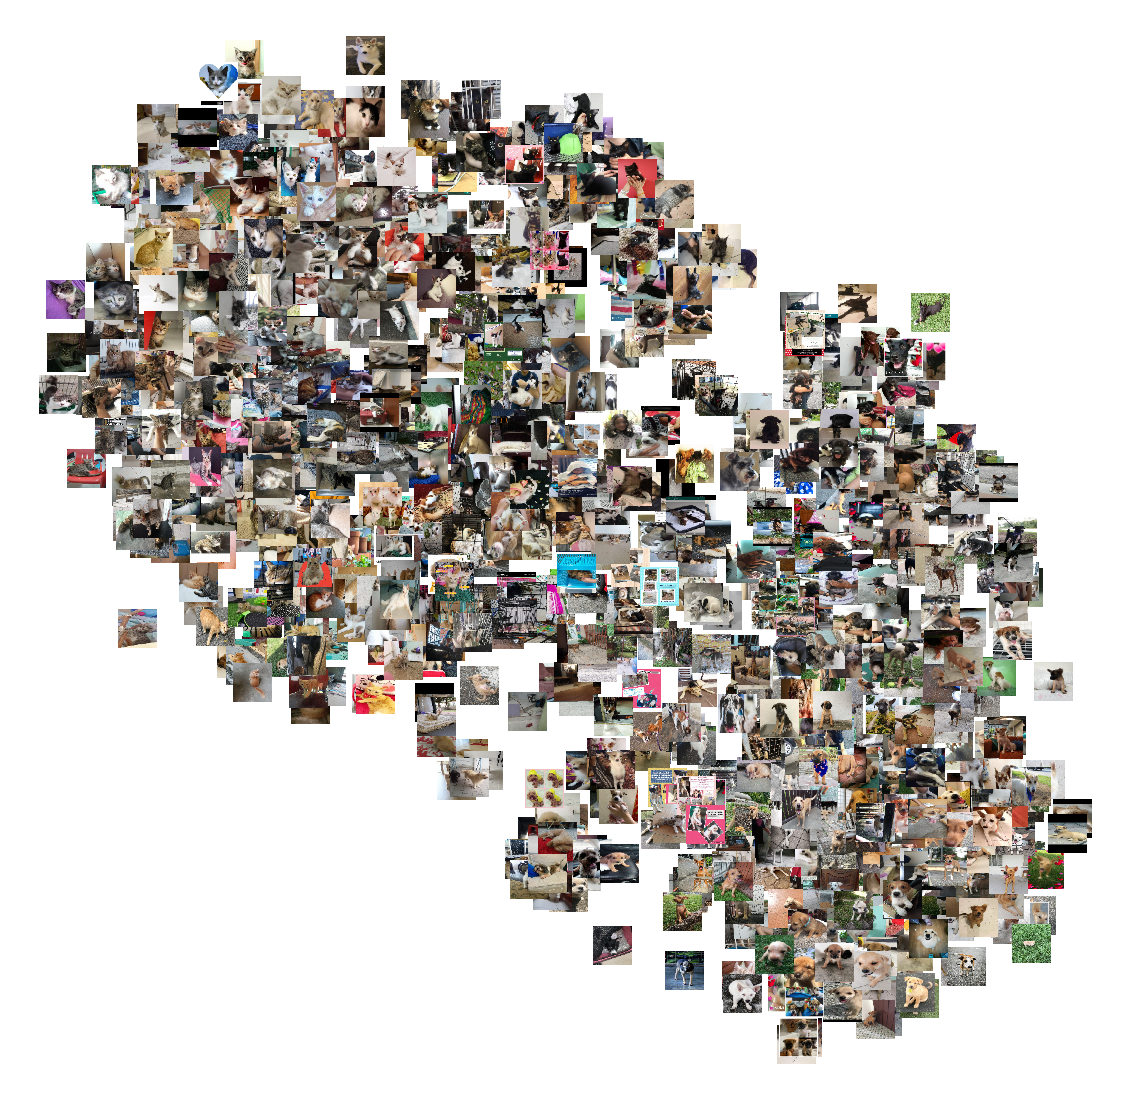

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
artists = []
for xy, i in zip(tsne_results, images):
    x0, y0 = xy
    img = OffsetImage(i, zoom=0.6)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(tsne_results)
ax.autoscale()
plt.axis('off')
plt.show()  

Very interesting to see that we clearly have 2 main clusters between cats and dogs!

# Work in Progress